In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg

# Load the datasets

In [ ]:
gdown

In [3]:
scrna = sc.read('../data/cao-2018/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 7362 × 4000
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [ ]:
gdown

In [5]:
scatac = sc.read('../data/cao-2018/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 7362 × 41524
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [8]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [9]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=1e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |████████████████████| 100.0% iter=10000/10000, time=21.74(s), loss=0.4862, recon=0.4857, kl=41.4021, integ=0.0000, cycle=0.0000, val_loss=0.4484, val_recon=0.4481, val_kl=32.3868, val_integ=0.0000, val_cycle=0.0000

### Plot training history

In [10]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.563947,0.563926,11.023441,0.0,0.0,0.465615,0.465581,11.865697,0,0
1,2000,0.504911,0.504830,17.564817,0.0,0.0,0.454994,0.454915,13.885660,0,0
2,3000,0.451002,0.450845,20.991019,0.0,0.0,0.452037,0.451881,18.250755,0,0
3,4000,0.475799,0.475538,26.669025,0.0,0.0,0.450868,0.450652,21.650215,0,0
4,5000,0.477987,0.477680,30.762408,0.0,0.0,0.450046,0.449787,25.858917,0,0
5,6000,0.461141,0.460792,34.829550,0.0,0.0,0.449633,0.449354,27.884850,0,0
6,7000,0.481445,0.481063,38.170224,0.0,0.0,0.449339,0.449046,29.272354,0,0
7,8000,0.467891,0.467490,40.125410,0.0,0.0,0.448942,0.448632,31.007736,0,0
8,9000,0.455931,0.455518,41.268146,0.0,0.0,0.448754,0.448444,31.065318,0,0
9,9999,0.486151,0.485737,41.402055,0.0,0.0,0.448390,0.448066,32.386787,0,0


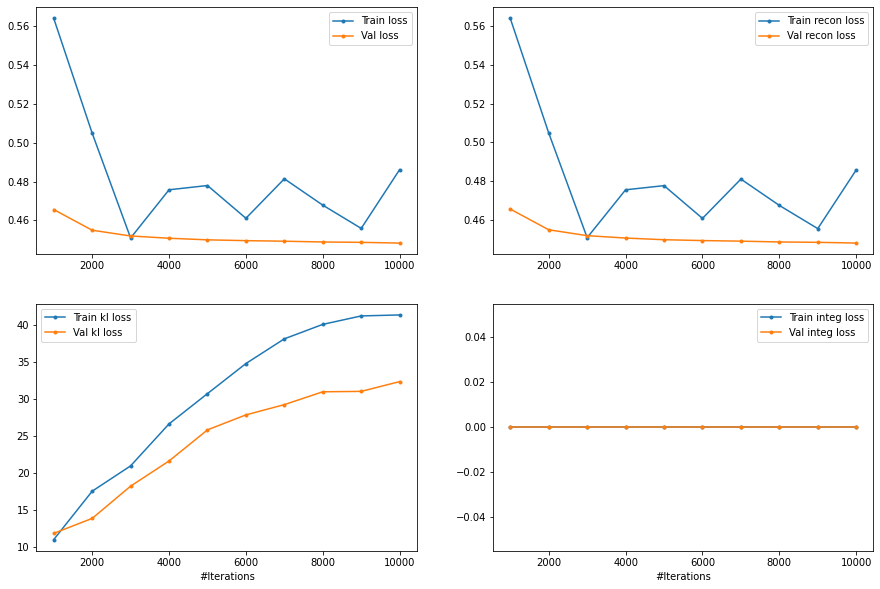

In [11]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [12]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    batch_size=256
)
z

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 7362 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [13]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  ada

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


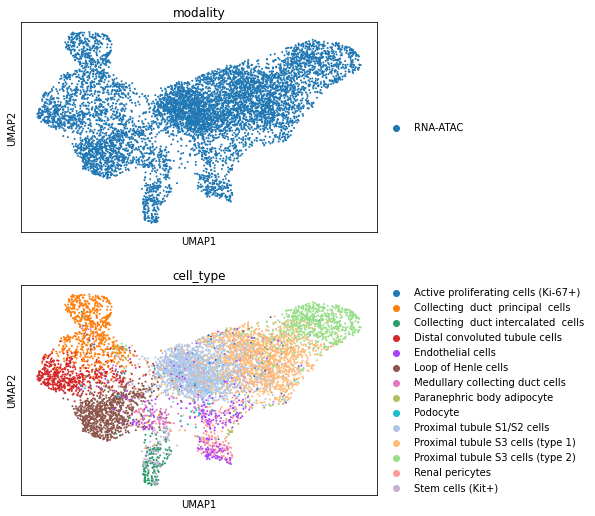

In [14]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

In [16]:
z.obs_names = z.obs.barcode
z.obs_names == scrna.obs_names

array([ True,  True,  True, ...,  True,  True,  True])

In [17]:
z.obs = scrna.obs

In [18]:
z.obs

,source,replicate,experiment,tsne_1,tsne_2,cell_type,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
sample,,,,,,,,,,,,,,
coRNA-RNA-plate1-001.CATGACTCAA,Mouse,Replicate 1,coassay,2.808426,-45.948924,Loop of Henle cells,414,414,6.028279,679.0,6.522093,13.0,2.639057,1.914580
coRNA-RNA-plate1-001.CGCCAGGCAT,Mouse,Replicate 1,coassay,-4.660380,-41.004499,Loop of Henle cells,415,414,6.028279,764.0,6.639876,23.0,3.178054,3.010471
coRNA-RNA-plate1-001.CCAGGCTCTT,Mouse,Replicate 2,coassay,10.309332,11.143745,Proximal tubule S1/S2 cells,879,878,6.778785,3342.0,8.114624,401.0,5.996452,11.998803
coRNA-RNA-plate1-001.GATTCCGGAA,Mouse,Replicate 1,coassay,1.061554,17.835682,Proximal tubule S1/S2 cells,328,328,5.796058,517.0,6.249975,18.0,2.944439,3.481625
coRNA-RNA-plate1-001.ACGCTTCTCT,Mouse,Replicate 2,coassay,-3.513582,-34.385932,Loop of Henle cells,741,741,6.609349,1607.0,7.382747,74.0,4.317488,4.604854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
coRNA-RNA-plate8-096.ACTGGTAGAT,Mouse,Replicate 1,coassay,22.516160,10.548511,Proximal tubule S3 cells (type 1),612,611,6.416732,1423.0,7.261225,34.0,3.555348,2.389318
coRNA-RNA-plate8-096.TTCTCTGAGA,Mouse,Replicate 1,coassay,12.374537,-1.020177,Proximal tubule S3 cells (type 1),953,951,6.858565,2450.0,7.804251,17.0,2.890372,0.693878
coRNA-RNA-plate8-096.GCTCGAATCA,Mouse,Replicate 2,coassay,34.541703,-6.368314,Proximal tubule S3 cells (type 2),272,272,5.609472,596.0,6.391917,15.0,2.772589,2.516778


In [19]:
z.write('../data/integrated/multigrate/cao-multigrate.h5ad')